In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load sentiment and market index data
finbert_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_finbert.xlsx')
textblob_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_textblob.xlsx')
vader_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/sorted_vader.xlsx')
spxd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXD.xlsx', sheet_name='Price Data')
spxtrd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/_SPXTRD.xlsx', sheet_name='Price Data')
vixd_data = pd.read_excel('C:/Users/22749/Desktop/UoG/Fintech/Dissertation/Data/VIXD.xlsx', sheet_name='Price Data')

# Ensure date columns are datetime type
for df in [finbert_data, textblob_data, vader_data, spxd_data, spxtrd_data, vixd_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Function to expand sentiment scores to daily
def expand_to_daily(data):
    return data.set_index('Date').resample('D').ffill().reset_index()

finbert_data_daily = expand_to_daily(finbert_data)
textblob_data_daily = expand_to_daily(textblob_data)
vader_data_daily = expand_to_daily(vader_data)

# Merge sentiment score data
sentiment_data = pd.merge(finbert_data_daily, textblob_data_daily, on='Date', how='outer', suffixes=('_finbert', '_textblob'))
sentiment_data = pd.merge(sentiment_data, vader_data_daily, on='Date', how='outer')

# Merge market index data
market_data = pd.merge(spxd_data, spxtrd_data, on='Date', how='outer', suffixes=('_spxd', '_spxtrd'))
market_data = pd.merge(market_data, vixd_data, on='Date', how='outer')

# Merge all data
data = pd.merge(sentiment_data, market_data, on='Date', how='outer')
data.set_index('Date', inplace=True)

# Drop rows with NaN values
data.dropna(inplace=True)

# Check merged data date range
print("Merged Data Date Range:")
print(data.index.min(), data.index.max())



Merged Data Date Range:
2021-12-17 00:00:00 2022-12-30 00:00:00


Validation Mean Squared Error: 0.1627369924917246
Validation Root Mean Squared Error: 0.40340673332472354
Validation Mean Absolute Error: 0.2881503350629619
Validation R^2 Score: 0.9874036432574997
Test Mean Squared Error: 0.22184617000846635
Test Root Mean Squared Error: 0.4710054882997292
Test Mean Absolute Error: 0.33330953228814997
Test R^2 Score: 0.9823448258259893


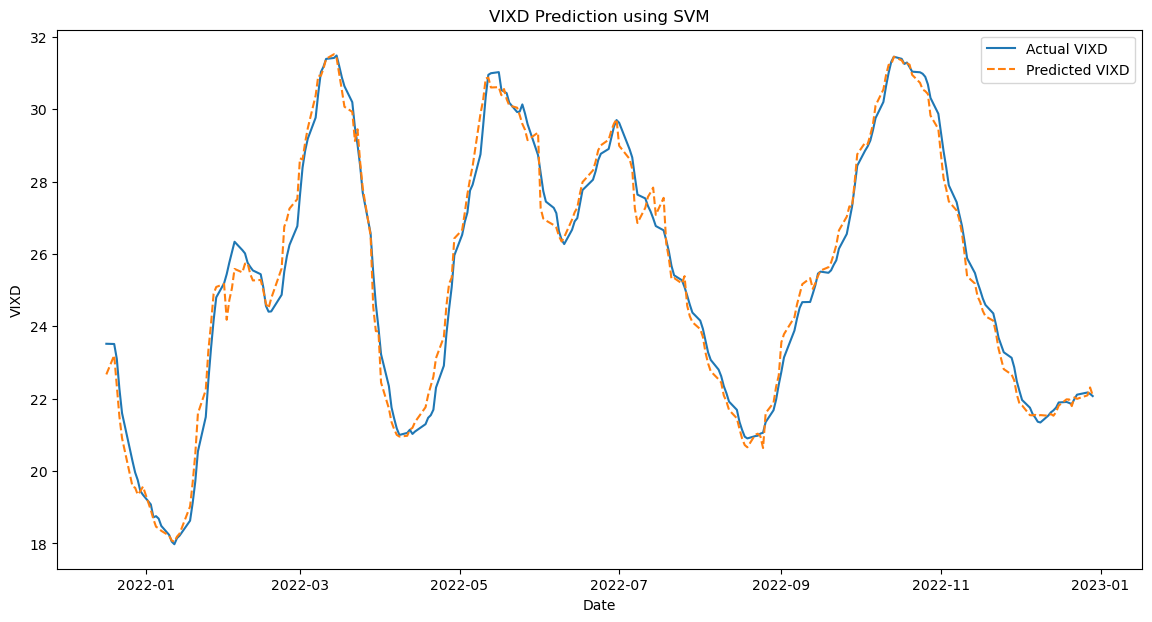

In [12]:
#Finbert + Textblob

# Select features and target
X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity',  
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]
y = data['Average_VIXD'].shift(-1)

# Drop NaN values from the target variable and align features
y = y.dropna()
X = X.loc[y.index]

# Apply weights to features
weights = {
    'Overall Positive Sentiment': 0.1,
    'Overall Neutral Sentiment': 0.7,
    'Overall Negative Sentiment': 0.1,
    'Polarity': 0.5,
    'Subjectivity': 0.5,
    'Average_SPXD': 0.7,
    'Close_SPXD': 0.7,
    'Close_SPXTRD': 0.7,
    'Average_SPXTRD': 0.7
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# Ensure features and target are aligned
X = X.loc[y.index]
data = data.loc[y.index]  # Synchronize deletion in data

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build SVM model
svm_model = SVR(kernel='rbf', C=1500, gamma=0.1)
svm_model.fit(X_train, y_train)

# 在验证集上评估模型
y_val_pred = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation Root Mean Squared Error: {val_rmse}')
print(f'Validation Mean Absolute Error: {val_mae}')
print(f'Validation R^2 Score: {val_r2}')

# 在测试集上评估模型
y_test_pred = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# Visualize prediction results
predicted_vixd = svm_model.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using SVM')
plt.legend()
plt.show()


In [13]:
import scipy.stats as stats

# 计算F统计量和P值
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, svm_model, X_val)
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, svm_model, X_test)
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 372.66494998050484
Validation P-value: 4.319373012729295e-37
Test F-statistic: 268.5061311381899
Test P-value: 3.753895726290587e-34


Validation Mean Squared Error: 0.2132721893646393
Validation Root Mean Squared Error: 0.46181402032056074
Validation Mean Absolute Error: 0.30983804182273766
Validation R^2 Score: 0.9802653986923076
Test Mean Squared Error: 0.06931628820808736
Test Root Mean Squared Error: 0.26327986669718473
Test Mean Absolute Error: 0.2001406862567691
Test R^2 Score: 0.9949539950690237


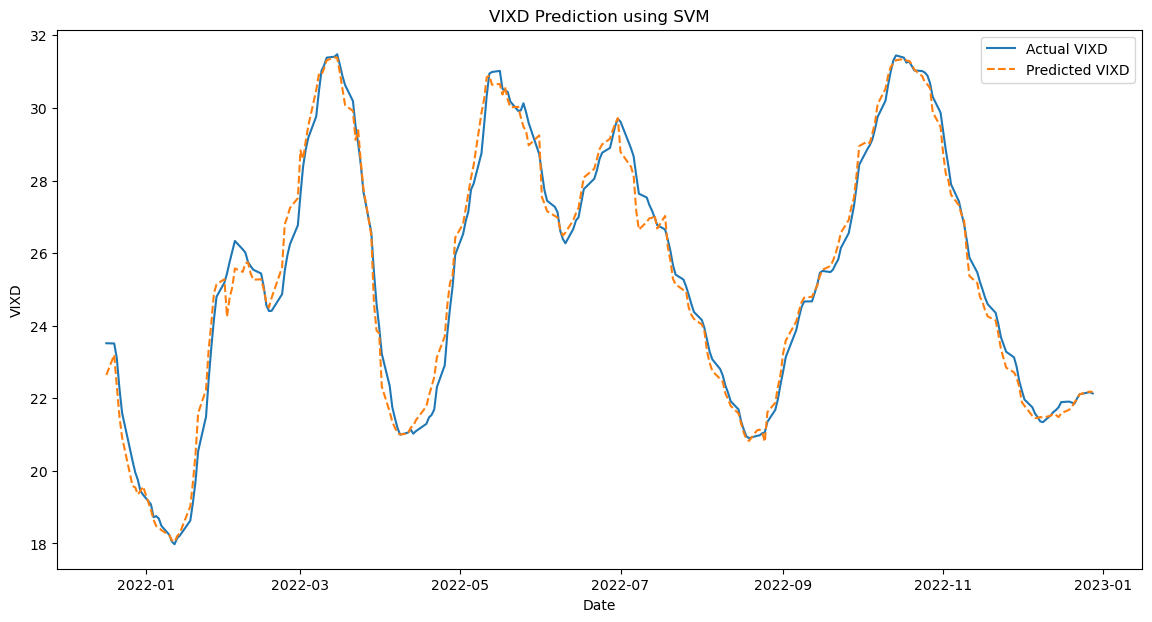

In [14]:
#Finbert + VADER
# Select features and target
X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment',  
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]
y = data['Average_VIXD'].shift(-1)

# Drop NaN values from the target variable and align features
y = y.dropna()
X = X.loc[y.index]

# Apply weights to features
weights = {
    'Overall Positive Sentiment': 0.1,
    'Overall Neutral Sentiment': 0.7,
    'Overall Negative Sentiment': 0.1,
    'Positive': 0.5,
    'Neutral': 0.5,
    'Negative': 0.5,
    'Average_SPXD': 0.7,
    'Close_SPXD': 0.7,
    'Close_SPXTRD': 0.7,
    'Average_SPXTRD': 0.7
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# Ensure features and target are aligned
X = X.loc[y.index]
data = data.loc[y.index]  # Synchronize deletion in data

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build SVM model
svm_model = SVR(kernel='rbf', C=1500, gamma=0.1)
svm_model.fit(X_train, y_train)

# 在验证集上评估模型
y_val_pred = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation Root Mean Squared Error: {val_rmse}')
print(f'Validation Mean Absolute Error: {val_mae}')
print(f'Validation R^2 Score: {val_r2}')

# 在测试集上评估模型
y_test_pred = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# Visualize prediction results
predicted_vixd = svm_model.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using SVM')
plt.legend()
plt.show()

In [15]:
import scipy.stats as stats

# 计算F统计量和P值
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, svm_model, X_val)
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, svm_model, X_test)
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 213.82213538731375
Validation P-value: 4.5718389582243307e-32
Test F-statistic: 797.8608285647049
Test P-value: 1.2108331219174372e-43


Validation Mean Squared Error: 0.21919539185246867
Validation Root Mean Squared Error: 0.46818307514525626
Validation Mean Absolute Error: 0.30965983084376575
Validation R^2 Score: 0.9804748681335975
Test Mean Squared Error: 0.08566758120483547
Test Root Mean Squared Error: 0.29269024788133186
Test Mean Absolute Error: 0.23096005079510223
Test R^2 Score: 0.993354608147345


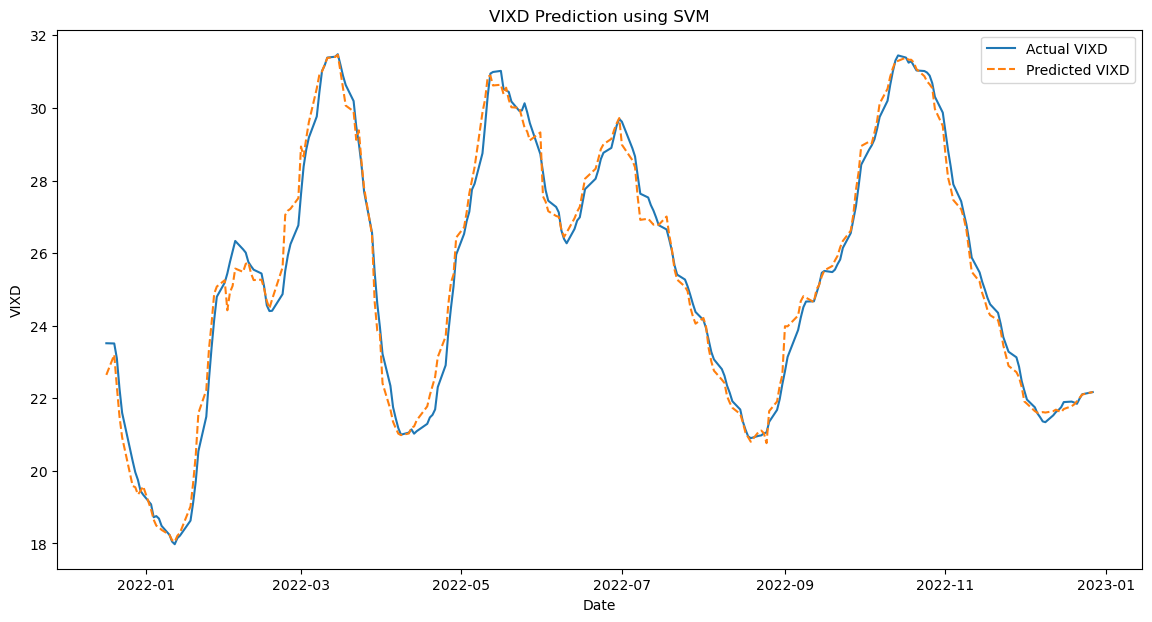

In [16]:
#Textblob + VADER
# Select features and target
X = data[[
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]
y = data['Average_VIXD'].shift(-1)

# Drop NaN values from the target variable and align features
y = y.dropna()
X = X.loc[y.index]

# Apply weights to features
weights = {
    'Polarity': 0.5,
    'Subjectivity': 0.5,
    'Positive': 0.5,
    'Neutral': 0.5,
    'Negative': 0.5,
    'Average_SPXD': 0.7,
    'Close_SPXD': 0.7,
    'Close_SPXTRD': 0.7,
    'Average_SPXTRD': 0.7
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# Ensure features and target are aligned
X = X.loc[y.index]
data = data.loc[y.index]  # Synchronize deletion in data

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build SVM model
svm_model = SVR(kernel='rbf', C=1500, gamma=0.1)
svm_model.fit(X_train, y_train)

# 在验证集上评估模型
y_val_pred = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation Root Mean Squared Error: {val_rmse}')
print(f'Validation Mean Absolute Error: {val_mae}')
print(f'Validation R^2 Score: {val_r2}')

# 在测试集上评估模型
y_test_pred = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# Visualize prediction results
predicted_vixd = svm_model.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using SVM')
plt.legend()
plt.show()

In [17]:
import scipy.stats as stats

# 计算F统计量和P值
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, svm_model, X_val)
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, svm_model, X_test)
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 242.2195917709582
Validation P-value: 3.122830599813722e-33
Test F-statistic: 695.6323941150582
Test P-value: 1.0092636880142439e-42


In [18]:
#lag 2

C:\Users\22749\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validation Mean Squared Error: 0.0993576604696134
Validation Root Mean Squared Error: 0.31521050183903043
Validation Mean Absolute Error: 0.22010728067334362
Validation R^2 Score: 0.9932434823749264
Test Mean Squared Error: 0.11408462114253319
Test Root Mean Squared Error: 0.3377641501736577
Test Mean Absolute Error: 0.2443085791821274
Test R^2 Score: 0.986609707837537


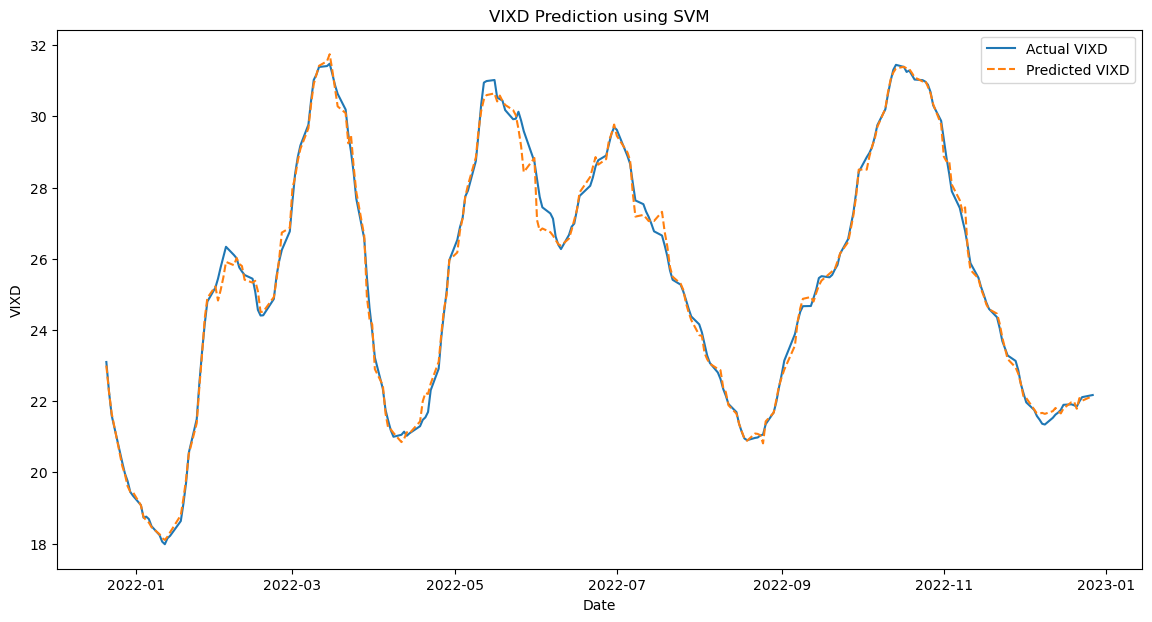

In [19]:
#Finbert + Textblob

# Select features and target with a lag of 2 days
lag = 2
X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Polarity', 'Subjectivity', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]

# Apply lag to the features
X_lagged = X.shift(lag)
y = data['Average_VIXD']

# Drop NaN values from the features and target variable
X_lagged = X_lagged.dropna()
y = y.loc[X_lagged.index]

# Apply weights to features
weights = {
    'Overall Positive Sentiment': 0.1,
    'Overall Neutral Sentiment': 0.7,
    'Overall Negative Sentiment': 0.1,
    'Polarity': 0.8,
    'Subjectivity': 0.5,
    'Average_SPXD': 0.9,
    'Close_SPXD': 0.9,
    'Close_SPXTRD': 0.9,
    'Average_SPXTRD': 0.9
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# Ensure features and target are aligned
X = X.loc[y.index]
data = data.loc[y.index]  # Synchronize deletion in data

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build SVM model
svm_model = SVR(kernel='rbf', C=1500, gamma=0.1)
svm_model.fit(X_train, y_train)

# 在验证集上评估模型
y_val_pred = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation Root Mean Squared Error: {val_rmse}')
print(f'Validation Mean Absolute Error: {val_mae}')
print(f'Validation R^2 Score: {val_r2}')

# 在测试集上评估模型
y_test_pred = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# Visualize prediction results
predicted_vixd = svm_model.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using SVM')
plt.legend()
plt.show()


In [20]:
import scipy.stats as stats

# 计算F统计量和P值
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, svm_model, X_val)
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, svm_model, X_test)
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 642.5765239818628
Validation P-value: 3.5230404955702806e-41
Test F-statistic: 341.5319361290065
Test P-value: 2.6250799576173745e-36


C:\Users\22749\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validation Mean Squared Error: 0.12455213383138831
Validation Root Mean Squared Error: 0.3529194438273249
Validation Mean Absolute Error: 0.2235570217150959
Validation R^2 Score: 0.991328402086663
Test Mean Squared Error: 0.13928926583990872
Test Root Mean Squared Error: 0.3732147717332591
Test Mean Absolute Error: 0.2733280072246275
Test R^2 Score: 0.9842984847019919


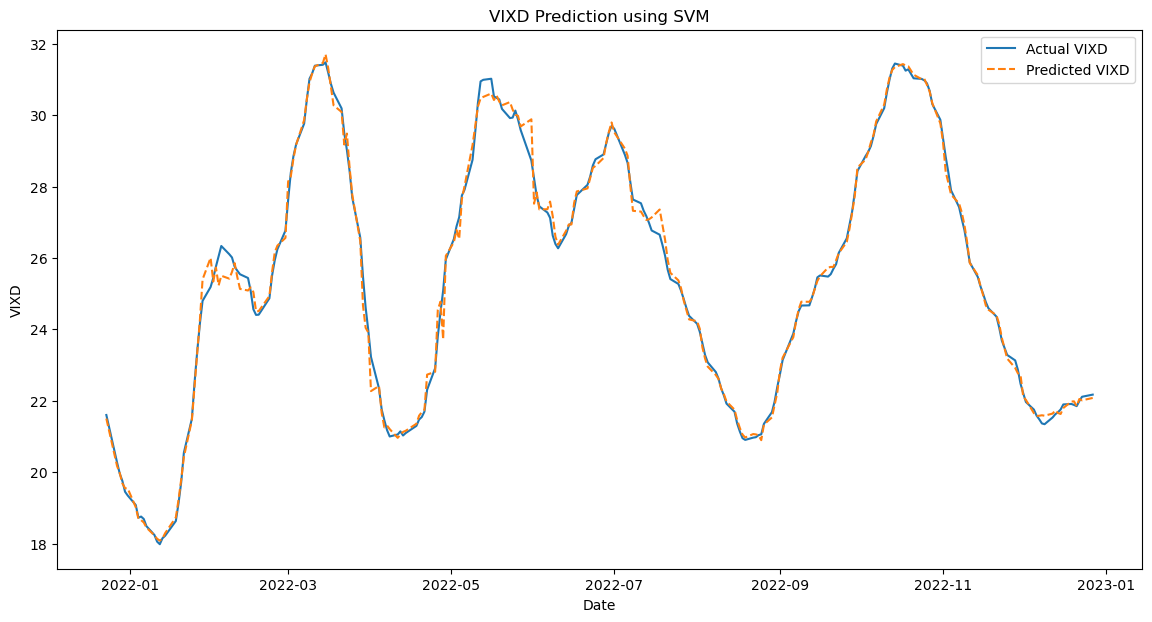

In [21]:
#Finbert + VADER
# Select features and target with a lag of 2 days
lag = 2
X = data[['Overall Positive Sentiment', 'Overall Neutral Sentiment', 'Overall Negative Sentiment', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]

# Apply lag to the features
X_lagged = X.shift(lag)
y = data['Average_VIXD']

# Drop NaN values from the features and target variable
X_lagged = X_lagged.dropna()
y = y.loc[X_lagged.index]

# Apply weights to features
weights = {
    'Overall Positive Sentiment': 0.1,
    'Overall Neutral Sentiment': 0.7,
    'Overall Negative Sentiment': 0.1,
    'Positive': 0.1,
    'Neutral': 0.1,
    'Negative': 0.5,
    'Average_SPXD': 0.9,
    'Close_SPXD': 0.9,
    'Close_SPXTRD': 0.9,
    'Average_SPXTRD': 0.9
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# Ensure features and target are aligned
X = X.loc[y.index]
data = data.loc[y.index]  # Synchronize deletion in data

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build SVM model
svm_model = SVR(kernel='rbf', C=1500, gamma=0.1)
svm_model.fit(X_train, y_train)

# 在验证集上评估模型
y_val_pred = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation Root Mean Squared Error: {val_rmse}')
print(f'Validation Mean Absolute Error: {val_mae}')
print(f'Validation R^2 Score: {val_r2}')

# 在测试集上评估模型
y_test_pred = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# Visualize prediction results
predicted_vixd = svm_model.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using SVM')
plt.legend()
plt.show()

In [22]:
import scipy.stats as stats

# 计算F统计量和P值
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, svm_model, X_val)
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, svm_model, X_test)
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 468.6414821579313
Validation P-value: 3.6548941914935357e-38
Test F-statistic: 248.85624263469606
Test P-value: 9.632211235385629e-33


C:\Users\22749\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validation Mean Squared Error: 0.04798876547986806
Validation Root Mean Squared Error: 0.21906338233458383
Validation Mean Absolute Error: 0.1596651269708181
Validation R^2 Score: 0.9961063282865456
Test Mean Squared Error: 0.2822338726636153
Test Root Mean Squared Error: 0.5312568801094395
Test Mean Absolute Error: 0.3278815246723105
Test R^2 Score: 0.9728816140567279


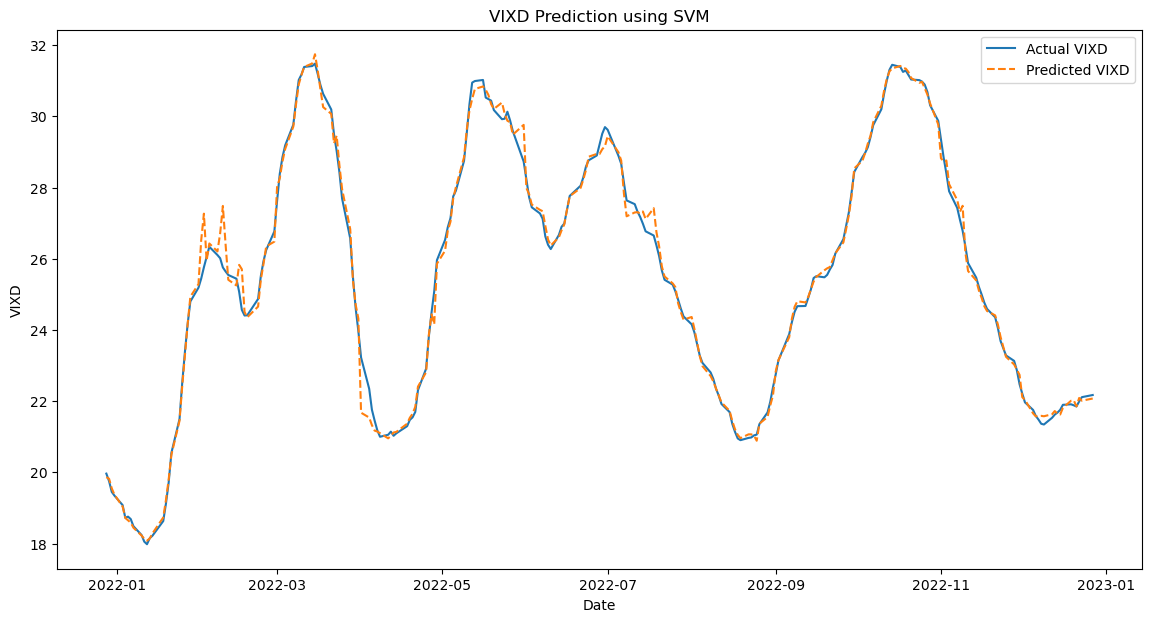

In [23]:
#Textblob + VADER
# Select features and target with a lag of 2 days
lag = 2
X = data[[ 
          'Polarity', 'Subjectivity', 
          'Positive', 'Neutral', 'Negative', 
          'Average_SPXD', 'Close_SPXD', 'Close_SPXTRD', 'Average_SPXTRD']]

# Apply lag to the features
X_lagged = X.shift(lag)
y = data['Average_VIXD']

# Drop NaN values from the features and target variable
X_lagged = X_lagged.dropna()
y = y.loc[X_lagged.index]

# Apply weights to features
weights = {
    'Polarity': 0.8,
    'Subjectivity': 0.5,
    'Positive': 0.1,
    'Neutral': 0.1,
    'Negative': 0.5,
    'Average_SPXD': 0.9,
    'Close_SPXD': 0.9,
    'Close_SPXTRD': 0.9,
    'Average_SPXTRD': 0.9
}
for col, weight in weights.items():
    X[col] = X[col] * weight

# Ensure features and target are aligned
X = X.loc[y.index]
data = data.loc[y.index]  # Synchronize deletion in data

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Build SVM model
svm_model = SVR(kernel='rbf', C=1500, gamma=0.1)
svm_model.fit(X_train, y_train)

# 在验证集上评估模型
y_val_pred = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation Root Mean Squared Error: {val_rmse}')
print(f'Validation Mean Absolute Error: {val_mae}')
print(f'Validation R^2 Score: {val_r2}')

# 在测试集上评估模型
y_test_pred = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test Mean Squared Error: {test_mse}')
print(f'Test Root Mean Squared Error: {test_rmse}')
print(f'Test Mean Absolute Error: {test_mae}')
print(f'Test R^2 Score: {test_r2}')

# Visualize prediction results
predicted_vixd = svm_model.predict(X_scaled)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Average_VIXD'], label='Actual VIXD')
plt.plot(data.index, predicted_vixd, label='Predicted VIXD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('VIXD')
plt.title('VIXD Prediction using SVM')
plt.legend()
plt.show()

In [24]:
import scipy.stats as stats

# 计算F统计量和P值
def calculate_f_p_values(y_true, y_pred, model, X):
    n = len(y_true)  # 样本数
    k = X.shape[1]  # 特征数
    ssr = np.sum((y_pred - y_true.mean()) ** 2)  # 回归平方和
    sse = np.sum((y_true - y_pred) ** 2)  # 残差平方和
    msr = ssr / k  # 回归均方
    mse = sse / (n - k - 1)  # 残差均方
    f_stat = msr / mse  # F统计量
    p_value = stats.f.sf(f_stat, k, n - k - 1)  # P值
    return f_stat, p_value

# 对验证集进行计算
f_stat_val, p_value_val = calculate_f_p_values(y_val, y_val_pred, svm_model, X_val)
print(f'Validation F-statistic: {f_stat_val}')
print(f'Validation P-value: {p_value_val}')

# 对测试集进行计算
f_stat_test, p_value_test = calculate_f_p_values(y_test, y_test_pred, svm_model, X_test)
print(f'Test F-statistic: {f_stat_test}')
print(f'Test P-value: {p_value_test}')


Validation F-statistic: 1147.0083737743512
Validation P-value: 2.3680896270368096e-45
Test F-statistic: 173.96294575739677
Test P-value: 9.673051663356126e-30
